In [1]:
import sys
sys.path = ['',
 '/cm/shared/sw/pkg-old/devel/python2/2.7.13/bin',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python27.zip',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/plat-linux2',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-tk',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-old',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/lib-dynload',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages',
 '/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages/IPython/extensions',
 '/mnt/home/llevasseur/.ipython']

In [2]:
import tensorflow as tf
import numpy as np

tf.enable_eager_execution()

/mnt/xfs1/flatiron-sw/pkg/devel/python2/2.7.13/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
execfile("definitions.py")

train_batch_size = 1
num_steps = 4
num_features = 512
state_size = 128

checkpoint_path_1 = "checkpoints/model1_512"
checkpoint_path_2 = "checkpoints/model2_512"


import matplotlib.pyplot as plt
%matplotlib inline  
from IPython import display
import pylab as pl



In [7]:
src_side = 20.48/2
im_side = 20.48

sk_gen = SRC_KAPPA_Generator(train_batch_size=train_batch_size,test_batch_size=train_batch_size,kap_side_length=im_side, num_src_side=num_features,num_kappa_side=num_features,src_side=src_side)
src_in , kap_in = sk_gen.draw_average_k_s()

RIM = RIM_UNET_CELL(train_batch_size , num_steps , num_features , state_size , cond1 = src_in , cond2 = kap_in)
lens_util_obj = lens_util(im_side= im_side, src_side=src_side, numpix_side = num_features ,kap_side=im_side,  method = "Unet")



physical_model = lens_util_obj.physical_model

noise_rms = 0.01
sk_gen.draw_k_s("test")

RESTORE=False
if (RESTORE):
    RIM.model_1.load_weights(checkpoint_path_1)
    RIM.model_2.load_weights(checkpoint_path_2)


In [10]:
optimizer = tf.train.AdamOptimizer(4e-4)

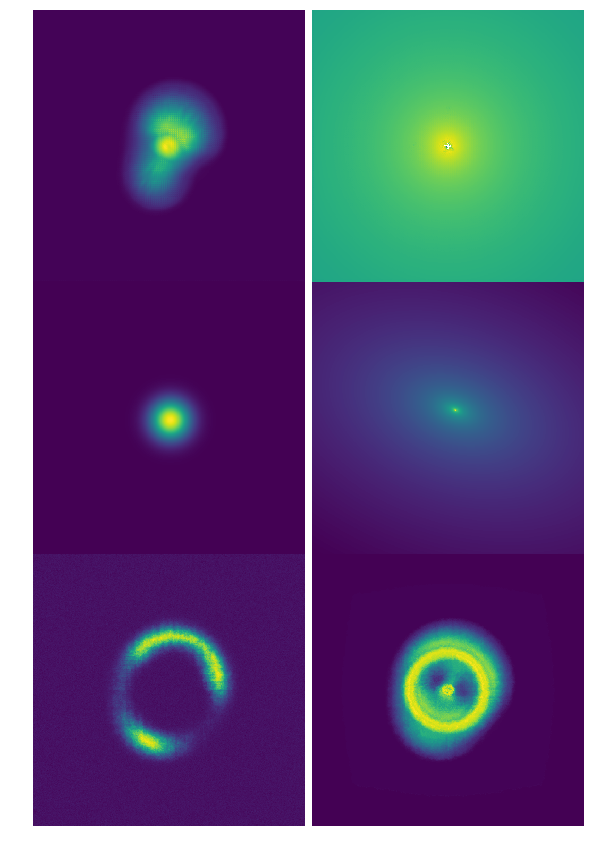

(399, 0.24509971)


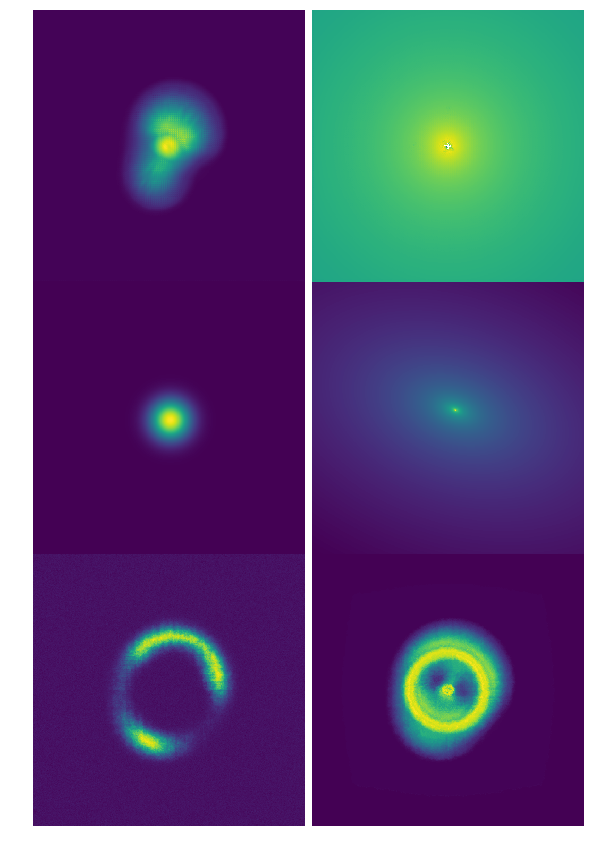

In [11]:
for train_iter in range(400):
    #if ((train_iter%1)==0):
    print train_iter
    sk_gen.draw_k_s("train")
    noisy_data = lens_util_obj.simulate_noisy_lensed_image(  sk_gen.Source_tr[:,:,:,:],sk_gen.Kappa_tr[:,:,:,:],noise_rms)
    tf_source =  tf.identity(sk_gen.Source_tr[:,:,:,:])
    tf_kappa  = tf.identity(sk_gen.Kappa_tr[:,:,:,:] )

    with tf.GradientTape() as tape:
        tape.watch(RIM.model_1.variables)
        tape.watch(RIM.model_2.variables)
        cost_value, _ , _ , OS_src , OS_kap = RIM.cost_function(noisy_data, tf_source , tf_kappa)
    weight_grads = tape.gradient(cost_value, [RIM.model_1.variables , RIM.model_2.variables] )

    clipped_grads_1 = [tf.clip_by_value(grads_i,-10,10) for grads_i in weight_grads[0]]
    optimizer.apply_gradients(zip(clipped_grads_1, RIM.model_1.variables), global_step=tf.train.get_or_create_global_step())
    clipped_grads_2 = [tf.clip_by_value(grads_i,-10,10) for grads_i in weight_grads[1]]
    optimizer.apply_gradients(zip(clipped_grads_2, RIM.model_2.variables), global_step=tf.train.get_or_create_global_step())
    print( train_iter , cost_value.numpy() )
    if (((train_iter+1)%1)==0):
        model_im = lens_util_obj.physical_model(OS_src , OS_kap)
        pl.clf()
        fig, ax = pl.subplots(3, 2, figsize = (10, 15))
        pl.subplots_adjust(wspace = 0, hspace = 0)
        imsrcP = ax[0, 0].imshow(OS_src[0,:,:,0])
        immodP = ax[0, 1].imshow(np.log10(OS_kap[0,:,:,0]))
        imsrcT = ax[1, 0].imshow(tf_source[0,:,:,0])
        imsrcT = ax[1, 1].imshow(np.log10(tf_kappa[0,:,:,0]))
        immodT = ax[2, 0].imshow(noisy_data[0,:,:,0])
        immodP = ax[2, 1].imshow(model_im.numpy()[0,:,:,0])
        for j in range(2):
            for i in range(3):
                ax[i,j].axis('off')    
        display.clear_output(wait=True)
        display.display(pl.gcf())
        print( train_iter , cost_value.numpy() )
#     if (((train_iter+1)%100)==0):
#         RIM.model_1.save_weights(checkpoint_path_1)
#         RIM.model_2.save_weights(checkpoint_path_2)
#         print('saved weights.')

In [ ]:
model_im = lens_util_obj.physical_model(OS_src , OS_kap)
pl.clf()
fig, ax = pl.subplots(3, 2, figsize = (10, 15))
pl.subplots_adjust(wspace = 0, hspace = 0)
imsrcP = ax[0, 0].imshow(OS_src[0,:,:,0])
immodP = ax[0, 1].imshow(OS_kap[0,:,:,0])
imsrcT = ax[1, 0].imshow(tf_source[0,:,:,0])
imsrcT = ax[1, 1].imshow(np.log10(tf_kappa[0,:,:,0]))
immodT = ax[2, 0].imshow(noisy_data[0,:,:,0])
immodP = ax[2, 1].imshow(model_im.numpy()[0,:,:,0])
for j in range(2):
    for i in range(3):
        ax[i,j].axis('off')    
display.clear_output(wait=True)
# display.display(pl.gcf())




In [ ]:
len(OS_src)

In [ ]:
len(cost_value)

In [ ]:
plt.figure()
plt.imshow(tf_source.numpy()[0,:,:,0])
plt.figure()
plt.imshow(np.log10(tf_kappa.numpy()[0,:,:,0]))
plt.figure()
plt.imshow(noisy_data.numpy()[0,:,:,0])

In [ ]:
xs , ys , ax , ay = lens_util_obj.get_deflection_angles(tf_kappa)

In [ ]:
plt.plot(xs[0,:,:,0],ys[0,:,:,0],' .');

In [ ]:
plt.imshow(ay[0,:,:,0])

In [ ]:
from skimage.transform import resize

In [ ]:
execfile("genSIEdef_angles.py")

In [ ]:
train_batch_size = 10
num_features = 512


RT = RayTracer()
kap_gen = SRC_KAPPA_Generator(train_batch_size=train_batch_size,kap_side_length=20.48,num_src_side=num_features,num_kappa_side=num_features)
checkpoint_path = "checkpoints/model_Unet"
RT.load_weights(checkpoint_path)


In [ ]:

ALFA = RT(tf_kappa)

In [ ]:
plt.imshow(ALFA[0,:,:,1])

In [ ]:
np.save('np_kappa.npy',tf_kappa.numpy())

In [ ]:
plt.imshow(np.log10(tf_kappa[0,:,:,0]))